In [ ]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
%matplotlib inline

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir dataset
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/Classification code/BinaryClasses_Dataset.rar", outdir="/content/dataset")

     |████████████████████████████████| 81kB 3.5MB/s 
patool: Extracting /content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/Classification code/BinaryClasses_Dataset.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/Classification code/BinaryClasses_Dataset.rar"
patool:     with cwd='/content/dataset'
patool: ... /content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/Classification code/BinaryClasses_Dataset.rar extracted to `/content/dataset'.


'/content/dataset'

In [ ]:
# Removing the original dataset forlder to get more free memory
#import shutil
path='dataset/'
shutil.rmtree(path, ignore_errors=False, onerror=None)

In [ ]:
dataDirectory= '/content/dataset'
train_path = dataDirectory+'/training'
test_path  = dataDirectory+'/testing'
print(os.listdir(train_path))
print(os.listdir(test_path))

['Defective', 'Normal']
['Defective', 'Normal']


In [ ]:
train_datagen = ImageDataGenerator(
        #rotation_range=40,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.1,
        fill_mode='nearest',
    validation_split=0.2) # set validation split

In [ ]:
selectedClasses = ['Normal', 'Defective'] 

In [ ]:
batchSize=10


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='validation') # set as validation data

test_generator = ImageDataGenerator().flow_from_directory(
    test_path, 
    target_size=(224,224), 
    classes=selectedClasses,
    shuffle= False,
    batch_size = batchSize)# set as test data

Found 2169 images belonging to 2 classes.
Found 541 images belonging to 2 classes.
Found 270 images belonging to 2 classes.


**Number of samples of each class in all data generators**

In [ ]:
print ("In train_generator ")
for cls in range(len (train_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(train_generator.classes).count(cls))
print ("") 

print ("In validation_generator ")
for cls in range(len (validation_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(validation_generator.classes).count(cls))
print ("") 

print ("In test_generator ")
for cls in range(len (test_generator.class_indices)):
    print(selectedClasses[cls],":\t",list(test_generator.classes).count(cls))

In train_generator 
Normal :	 1207
Defective :	 962

In validation_generator 
Normal :	 301
Defective :	 240

In test_generator 
Normal :	 135
Defective :	 135


**Auxilary Functions for ploting images**

In [ ]:
def plots(ims, figsize = (10,10), rows=4, interp=False, titles=None, maxNum = 9):
    if type(ims[0] is np.ndarray):
        ims = np.array(ims).astype(np.uint8)
        if(ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
           
    f = plt.figure(figsize=figsize)
    #cols = len(ims) //rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    cols = maxNum // rows if maxNum % 2 == 0 else maxNum//rows + 1
    #for i in range(len(ims)):
    for i in range(maxNum):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=20)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

**Plot some train data**

In [ ]:
train_generator.reset()
imgs, labels = train_generator.next()

#print(labels)

labelNames=[]
labelIndices=[np.where(r==1)[0][0] for r in labels]
#print(labelIndices)

for ind in labelIndices:
    for labelName,labelIndex in train_generator.class_indices.items():
        if labelIndex == ind:
            #print (labelName)
            labelNames.append(labelName)

#labels

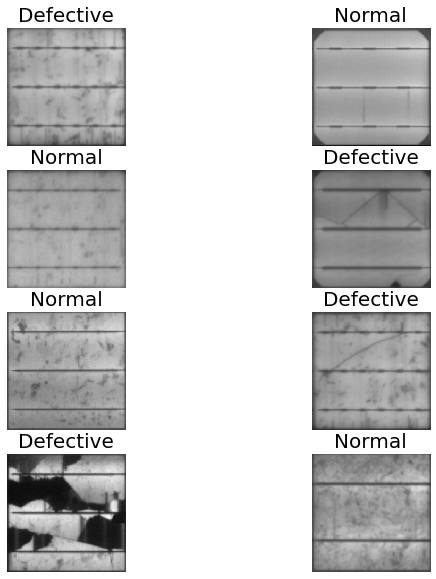

In [ ]:
plots(imgs, rows=4, titles = labelNames, maxNum=8)


**Create model by Transfer Learning from InceptionV3**

In [ ]:
#InceptionV3

base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
# and a sofymax/logistic layer -- we have 6 classes
predictions = Dense(len(selectedClasses), activation='sigmoid')(x)

# this is the model we will train
model = Model(base_model.input, predictions)
#model.summary()

In [ ]:
#Atutomatic rename with epoch number and val accuracy:
#filepath="checkpoints/weights-improvement-epeoch-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5"

modelName= "InceptionV3"
#save the best weights over the same file with the model name

#filepath="checkpoints/"+modelName+"_bestweights.hdf5"
filepath=modelName+"_bestweights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

**Compile the model**

In [ ]:
model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


**Train the model**

In [ ]:
stepsPerEpoch= (train_generator.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(validation_generator.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)

#validationSteps=(test_generator.samples+ (batchSize-1)) // batchSize
#print("validationSteps: ", validationSteps)

stepsPerEpoch:  217
validationSteps:  55


In [ ]:
train_generator.reset()
validation_generator.reset()

# Fit the model
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs = 20,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=1)

**Show Training History**
We can plot the accuracy and loss values for each epoch using the history object as follows.

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Save the model and last weights**

In [ ]:
timestr = time.strftime("%Y%m%d_%H%M%S")

# serialize model to JSON
model_json = model.to_json()
with open(modelName+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(modelName+"_3_LAST_WEIGHTS_"+".h5")

In [ ]:
# copy the model to mydrive
!cp '/content/ResNet50_3_LAST_WEIGHTS_.h5' '/content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/ResNet50_3_LAST_WEIGHTS_.h5'

**Upload the model and best weights**

In [ ]:
# load json and create model
json_file = open('ResNet50_MODEL_3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [ ]:
# load weights into new model
model.load_weights("/content/drive/MyDrive/Colab Notebooks/Defective_Solar_Cells_project/Classification code/Inception_3_LAST_WEIGHTS_.h5")

**Evaulate the model**

In [ ]:
model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
test_generator.reset()
score = model.evaluate_generator(test_generator, (test_generator.samples + (batchSize-1)) // batchSize)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


For test data set; Loss:  0.23461687564849854  Accuracy:  0.9518518447875977


**Make Predictions**

In [ ]:
test_generator.reset()
testStep = (test_generator.samples + (batchSize-1)) // batchSize
print("testStep: ", testStep)
predictions = model.predict_generator(test_generator, steps = testStep ,  verbose = 1)
len(predictions)

testStep:  27


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


27/27 [==============================] - 3s 78ms/step


270

In [ ]:
len(predictions)


270

**Decode Labels**

In [ ]:
predicted_class_indices=np.argmax(predictions,axis=1)
print(predicted_class_indices)
len(predicted_class_indices)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1]


270

In [ ]:
labels = (test_generator.class_indices)
print(labels)

{'Normal': 0, 'Defective': 1}


In [ ]:
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'Normal', 1: 'Defective'}


In [ ]:
predictedLables= [labels[k] for k in predicted_class_indices]
print(predictedLables)
len(predictedLables)

['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Defective', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Defective', 'Normal', 'Normal', 'Defective', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Defective', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Defective', 'Normal', 'Normal', 'Nor

270

**predictedLabels** have the labels predicted by the model. We need to locate the actual labels for the same test data as follows

In [ ]:
actualLables= [labels[k] for k in test_generator.classes]
print(actualLables)
len(actualLables)

['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',

270

**Evaulate the results**
Below, we will see several methods for evaluating a classifier.

**Accuracy**
The most classical evaluation metric for classifiers is the accuracy, which corresponds to the proportion of correctly classified instances.


In [ ]:
accuracy_score(actualLables, predictedLables)

0.9740740740740741

**Evaluation metrics based on a confusion matrix**

A confusion matrix is such that the cell at row i and column j is equal to the number of observations known to be in group i but predicted to be in group j .

In [ ]:
matrix = confusion_matrix(actualLables, predictedLables)
print(labels)
matrix

{0: 'Normal', 1: 'Defective'}


array([[130,   5],
       [  3, 132]])

In [ ]:
TP = matrix[1, 1]
TN = matrix[0, 0]
FP = matrix[0, 1]
FN = matrix[1, 0]
print(TP,TN,FP,FN)

132 130 5 3


In [ ]:
specificity = TN / (TN + FP)
print(specificity)

0.9407407407407408


**The precision and recall metrics**

In [ ]:
print(classification_report(actualLables, predictedLables))


              precision    recall  f1-score   support

   Defective       1.00      0.96      0.98       135
      Normal       0.96      1.00      0.98       135

    accuracy                           0.98       270
   macro avg       0.98      0.98      0.98       270
weighted avg       0.98      0.98      0.98       270



In [ ]:
# Compute Sensitivity (Recall)
Recall_Score = recall_score( actualLables, predictedLables,average='weighted') 
Recall_Score

0.9777777777777777

In [ ]:
Precision_Score = precision_score( actualLables, predictedLables,average='weighted') 
Precision_Score

0.9787234042553191

In [ ]:
F1_score = 2*((Recall_Score * Precision_Score)/(Recall_Score + Precision_Score))
F1_score

0.9782503624939584

**Plot the confusion matrix**

In [ ]:
#Prepared code that is taken from SKLearn Website, Creates Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[129   6]
 [  0 135]]


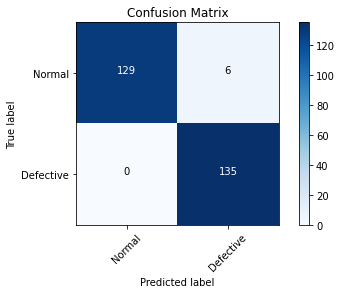

In [ ]:
cm_plot_labels = selectedClasses
plot_confusion_matrix(matrix,cm_plot_labels, normalize=False
                      , title = 'Confusion Matrix')


In [ ]:
import numpy as np
array1=np.zeros(135)
array2=np.ones(135)
y_test=np.concatenate([array1,array2])
print(y_test)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predicted_class_indices)

In [ ]:
auc_score=roc_auc_score(y_test, predicted_class_indices)  #0.8822
auc_score

0.9518518518518518

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predicted_class_indices)
# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9518518518518518


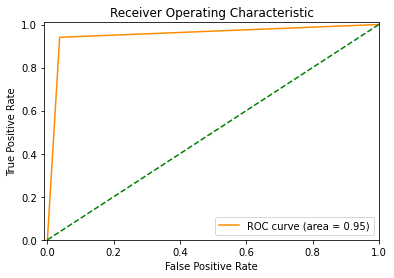

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

**Save Predictions**

Finally, save the results to a CSV file.

In [ ]:
filenames=test_generator.filenames
directory= test_generator.directory
results=pd.DataFrame({"Directory":directory,
                      "Filename":filenames,
                      "Predictions":predictedLables,
                     "Actuals": actualLables })
results.to_csv("results.csv",index=False)


**Show some sample predictions with corresponding true labels**

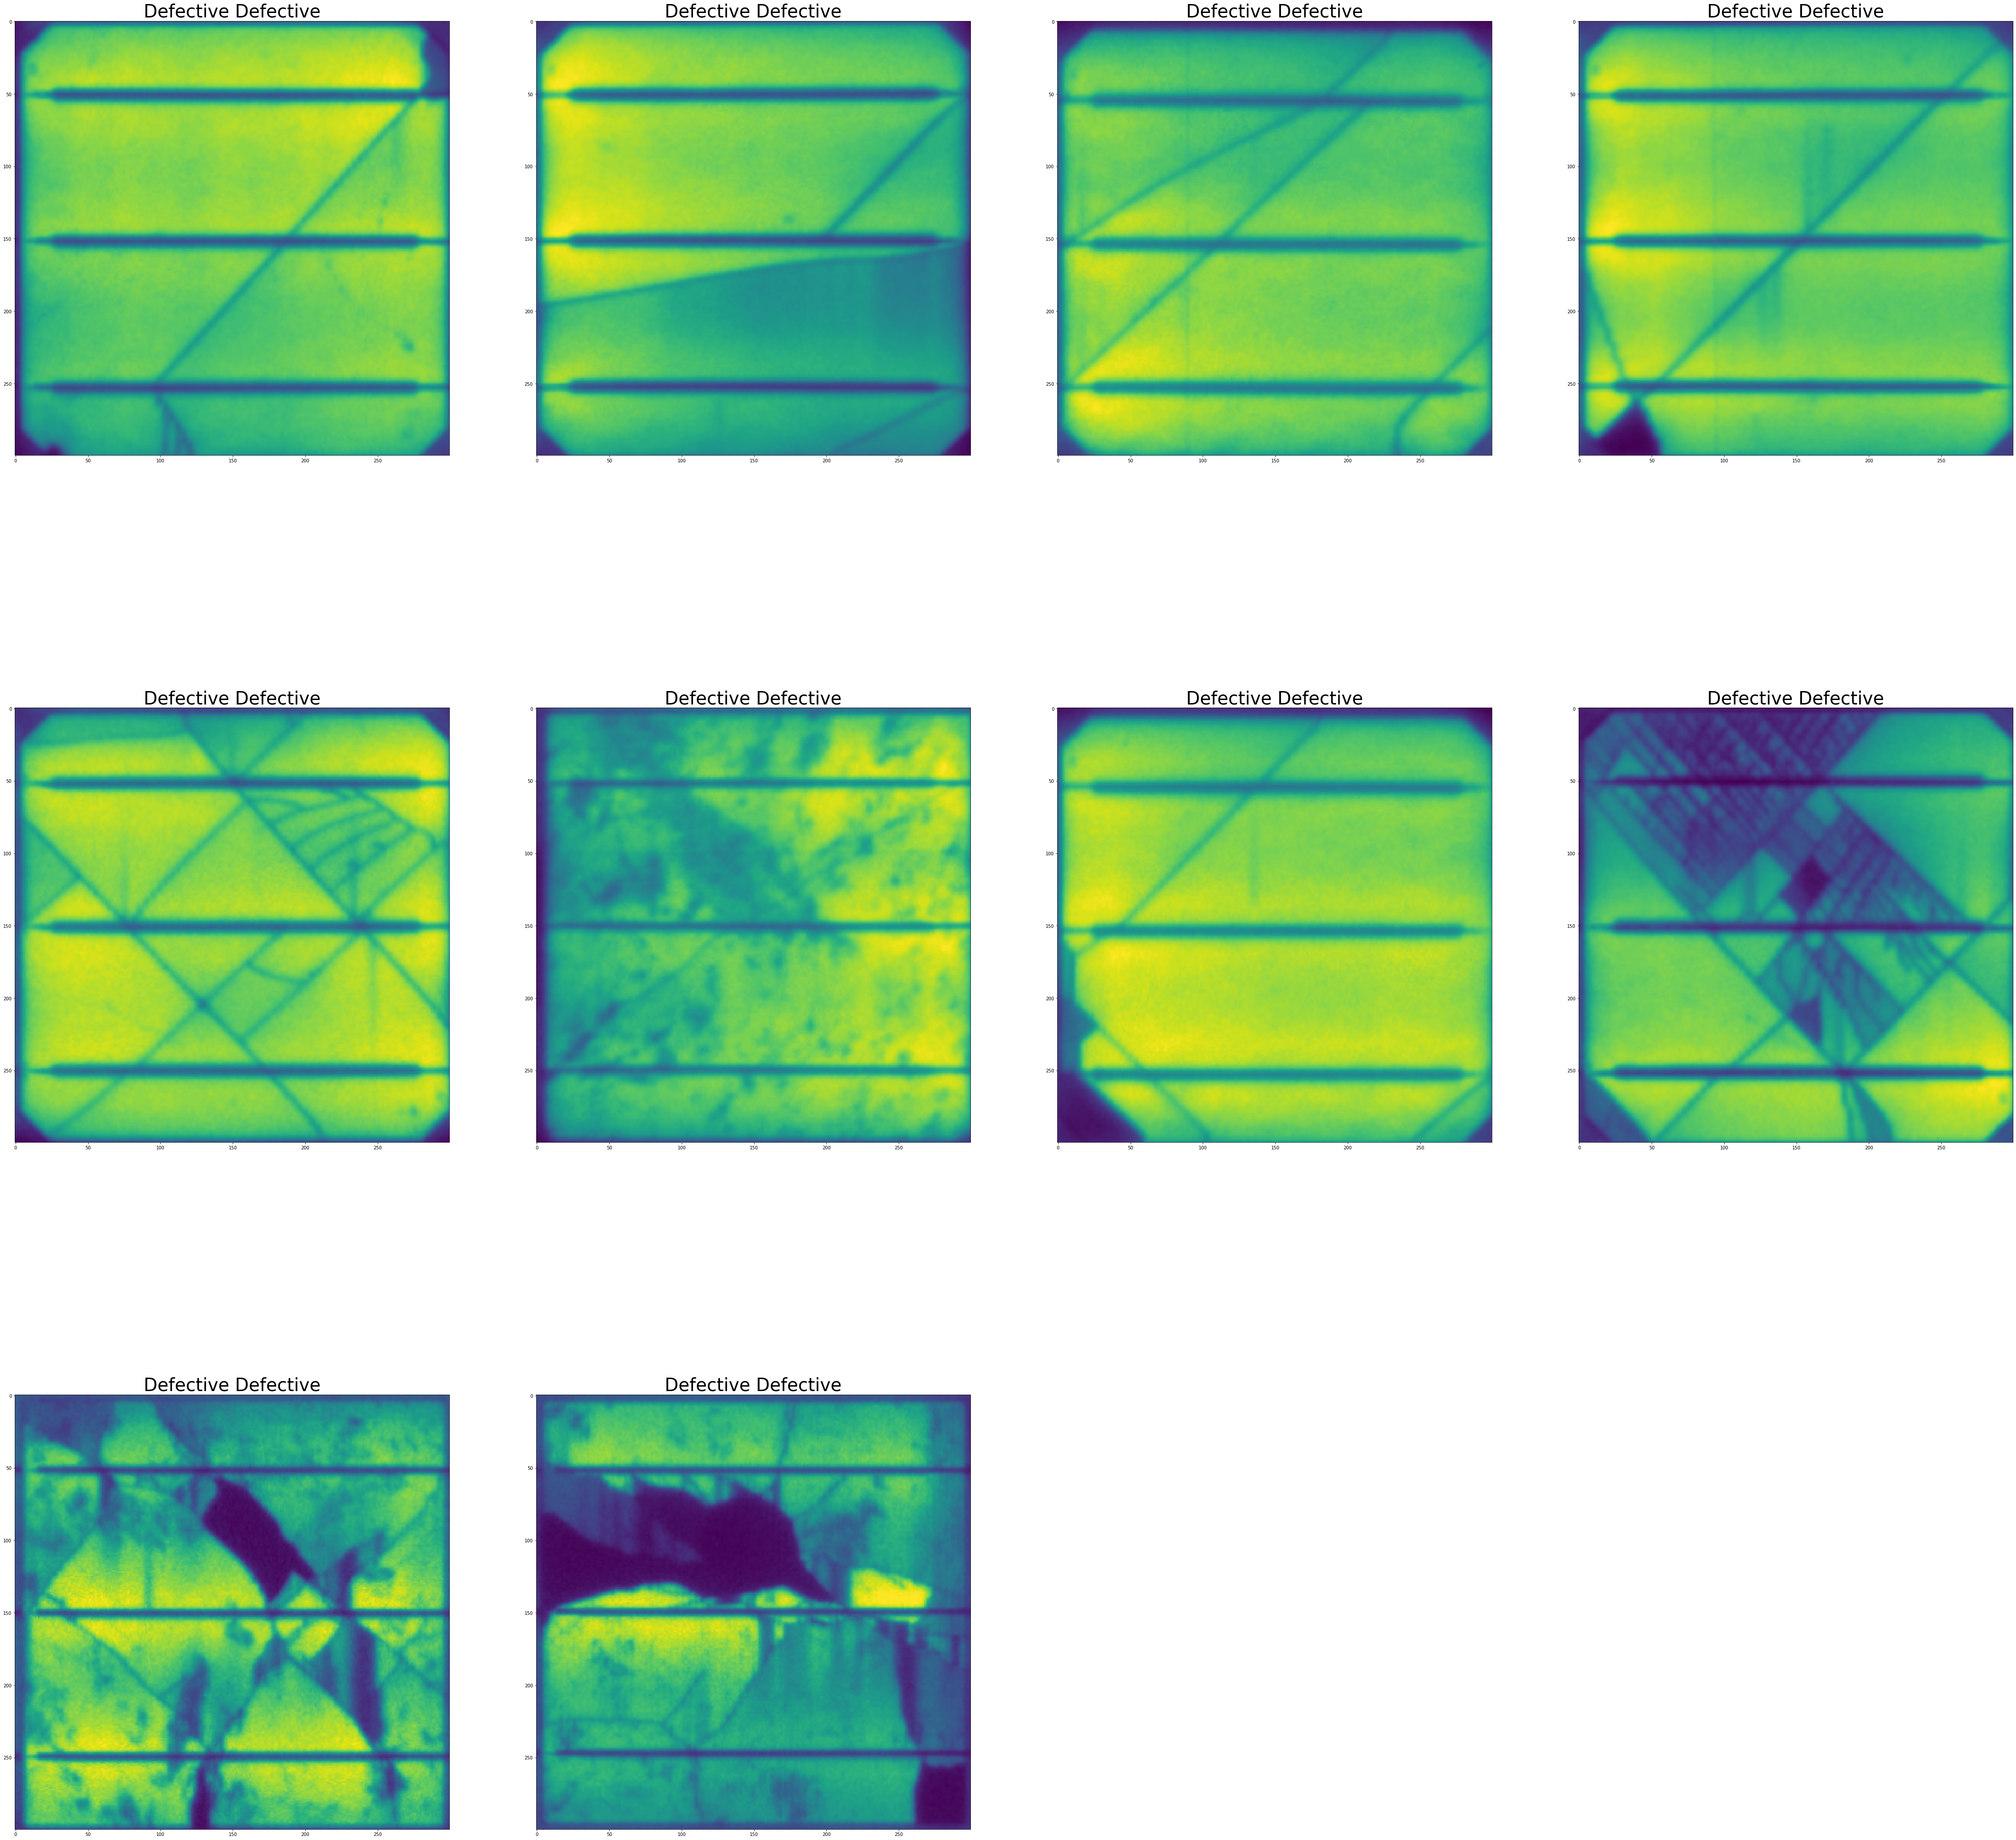

In [ ]:
#import glob
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

res = results[260:280]

images = []
#for img_path in glob.glob('images/*.jpg'):
for img_path in "/"+res['Directory']+"/"+res['Filename']:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(80,80))
columns = 4
for i, image in enumerate(images):
    ax= plt.subplot(len(images) / columns + 1, columns, i + 1)
    ax.set_title(res['Actuals'].iloc[i]+" "+res['Predictions'].iloc[i], fontsize=40)
    plt.imshow(image)